In [1]:
# size dist plus growth rates
import numpy as np

import matplotlib.pyplot as plt
import seaborn
% matplotlib inline
from scipy.stats import norm
from scipy.stats import pareto

import pandas as pd

from scipy.special import erf


### Empirical number of agents and total value
Recommendation: 

1e5 agents. 

~1e11.5 EUR annually 

In [3]:
data_path = './../../data/processed/'

df = pd.read_csv('./../../data/processed/ID_Y.csv')
df = df.loc[df.IMPORT == 0]
empirical = df.groupby(['YEAR']).agg({'ID': 'count', 'VART': 'sum'}) # count == nunique

In [4]:
# We'll try different N's, until we can match the avg level of France imports 

tot_val = []
Ns = np.array(np.round(np.power(10, np.arange(4.5, 5.5, .01))), dtype = int)

for N in Ns:
    N_ = int(round(N/(1 - cum_th))) # We use a larger N ..
    draw = np.random.normal(mu, sigma, N_) # so that approximately we'll have N guys above x = 3
    draw = np.sort(draw)[-N:]
    tot_val += [np.power(10, draw).sum()] # (=y)

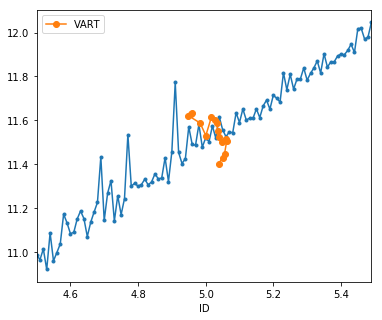

In [5]:
fig, ax = plt.subplots(1, figsize = (6, 5))

ax.plot(np.log10(Ns), np.log10(tot_val), marker = '.')
np.log10(empirical).plot('ID', 'VART', marker = 'o', ax = ax)
plt.show()
# *think that mu, sigma are for pooled data, but they could be different in each year.

## Size distributions

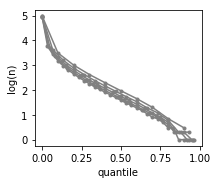

In [4]:
# The size dists are:
#  - Lognormal clipped x > 3. 
sigma = 1.3149476902828778
mu = 4.470439741406725
# 13% of guys that would be below the .3 threshold.
z = (mu - 3)/sigma
cum_th = 1 - .5*(1 + erf(z/np.sqrt(2)))


N = int(1e5)
N_ = int(round(N/(1 - cum_th))) # We use a larger N ..
draw = np.random.normal(mu, sigma, N_) # so that approximately we'll have N guys above x = 3
draw = np.sort(draw)[-N:]

# Now we can have the n(Q, q)
def get_n(x1, Q):
    x_lin = np.power(10, x1)
    bins = pd.cut(pd.Series(np.cumsum(x_lin)), Q)
    ns = bins.value_counts().values
    return bins, ns

# From the theoretical N and the ppf we can know the theoretical quantiles
x_logn_clip3 = np.array([norm.ppf(q, mu, sigma) for q in np.arange(0, 1, 1/N_) + .5/N_])
x_logn_clip3 = x_logn_clip3[(-N - 1):-1]

## N tail for pareto and lognormal tail
N_tail = get_n(x_logn_clip3, 10)[1][1:].sum()

fig, ax = plt.subplots(1, figsize = (3, 2.5))

for Q in [10, 15, 20, 25, 30]:
    ns = get_n(x_logn_clip3, Q)[1]
    ax.plot(np.arange(Q)/Q, np.log10(ns), marker = '.', c = '.5')
plt.xlabel('quantile')
plt.ylabel('log(n)')
plt.show()


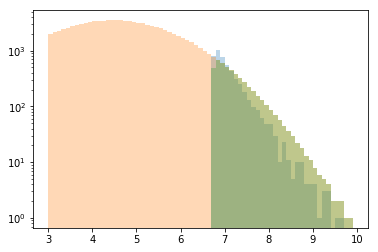

4891 11.124086001384805
100000 11.504401611422596
4891 11.458644119793735


In [6]:
n = N_tail
x_logn_clip3_90 = x_logn_clip3[-N_tail:]

# PARETO
z_0 = -1.1771
value_qs_1 = x_logn_clip3_90.min() # 6.761 in the original fit
x_pareto = np.log10(np.random.pareto(-z_0, n) + 1 ) + value_qs_1
# r = np.log10(pareto.rvs(b = -z_0, size = n, scale = 10**value_qs_1) + 1)
# plt.hist(r, bins_, alpha = .3)


# Plot Histogram. Distribution debug
bins_ = np.arange(3, 10, .1)
plt.hist(x_pareto, bins_, alpha = .3)
plt.hist(x_logn_clip3, bins_, alpha = .3)
plt.hist(x_logn_clip3_90, bins_, alpha = .3)


plt.yscale('log')
plt.show()

# Check population and value in all three size dists. 
for x in [x_pareto, x_logn_clip3, x_logn_clip3_90]:
    print(len(x), np.log10(np.power(10, x).sum()))

In [48]:
np.log10(np.power(10, 11.504401611422596)*.9) # perfect

11.458644120861921

In [ ]:
# pareto.pdf(x, b, loc, scale)
# pareto.pdf((x - loc) / scale, b) / scale

In [7]:
# # Need to reconciliate... For the moment I use quick and dirty... just sort the random generated..
# # x1 = np.array([pareto.ppf(b = -z_0, scale = 10**value_qs_1) for q in np.arange(0, 1, 1/N_tail) + .5/N_tail])
# # np.log10(pareto.rvs(b = -z_0, size = n, scale = 10**value_qs_1) + 1)
# # x1 = x1[(-N_tail - 1):-1]

# pareto_array = np.log10(np.random.pareto(-z_0, N_tail) + 1 ) + value_qs_1
# # pareto_array = np.log10(pareto.rvs(b = -z_0, size = n, scale = 10**value_qs_1) + 1)
# x1 = np.sort(pareto_array)

## Empirical GR

In [14]:
gr_info = pd.read_csv('./../../data/processed/g_rates_info.csv')

In [20]:
T = 16
x0 = pd.Series(draw)
g_rates_list = []

# size dependent growth rates
for s in np.arange(3, 11.5, .5):
    x0_s = x0.loc[abs(x0 - s) < .25]
    gr_s = gr_info.loc[abs(gr_info.level - s) < .5]  
    
    if len(gr_s) > 0:
        g_rates_long = gr_s.sample(len(x0_s) * int(T/2), replace = True)
        g_rates = g_rates_long[['logdiff1', 'logdiff2']].values.reshape(len(x0_s), T)
        g_rates_list += [g_rates]
    
g_rates = pd.DataFrame(np.vstack(g_rates_list))

# If T is made many x T we could have repetitions with little effort...

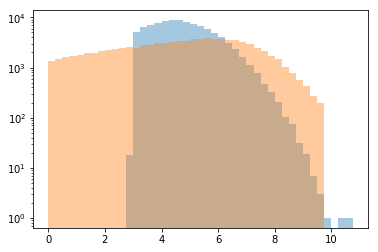

In [21]:
plt.hist(x0.values, np.arange(0, 11, .25), alpha = .4)
plt.hist(x0.values + g_rates.cumsum(axis = 1)[15], np.arange(0, 10, .25), alpha = .4)
plt.yscale('log')
plt.show()

In [22]:
# There is some issue, distribution gets deformed over time.

## Modeled GR
- Non correlated
    - Gaussian (a = 2)
    - Laplace (a = 1)
    - Subbotin (a = 1/2)

In [10]:
from scipy.stats import gennorm

In [50]:
# x0 = pd.Series(draw)
# x1 is the exact distribution

I = 600
T = 16

# for j, x1 in enumerate([x_pareto, x_logn_clip3_90]):#, x_logn_clip3]):
for j, x1 in enumerate([x_logn_clip3]):
    N = len(x1)
#     sizes = ['pareto', 'logn90', 'logn'][j]
    sizes = ['logn'][j]
    print(sizes)
    for k, dist in enumerate(['norm', 'lapl']):#, 'sbtn']):
        print(dist)
        var_result = []
        for s in [.1, .2, .3, .4, .5]:
        # for s in [.1]:
            print(s)
            for Q in [10, 20]:#15, 20, 25]:
        #     for Q in [10]:
                print(Q)
                bins, ns = get_n(x1, Q)
                for i in range(I):
                    if i%100 == 0: print(i)
                    if dist == 'norm':
                        g_rates = np.random.normal(0, s, (N, T + 1))
                    elif dist == 'lapl':
                        g_rates = np.random.laplace(0, s, (N, T + 1))/np.sqrt(2)
                    else:
                        g_rates = gennorm.rvs(1/2, size = (N, T + 1))
                    # # If T is made many x T we could have repetitions with little effort...
                    g_rates = (g_rates.T - g_rates.mean(axis = 1)).T
                    gr_cs = g_rates.cumsum(axis = 1)
                    xt = (gr_cs.T + x1).T

                    st = np.power(10, xt)
                    lin_levs = pd.DataFrame(st, index = bins)
                    bin_ix_mapper = dict(zip(bins.unique(), range(bins.nunique())))
                    lin_levs.index = lin_levs.index.map(bin_ix_mapper); lin_levs.index.name = 'q'

                    # see if quantiles tend to have more or less a constant part ofthe value
                    # df.groupby(level = 0).sum().reset_index(drop = True).T.plot()

                    # The sum of this simulated quantile q, Q, i
                    lin_levs_i = lin_levs.groupby(level = 0).sum()
                    # The key line. # Variance of each quantile. 
                    out_df = lin_levs_i.copy()
                    out_df['var_qi'] = np.log10(lin_levs_i).var(axis = 1)
                    out_df['var_diff_qi'] = np.log10(lin_levs_i).diff(axis = 1).var(axis = 1)
                    out_df['i'] = i
                    out_df['Q'] = Q
                    out_df['s'] = s
                    out_df['var_agg_i'] = np.log10(lin_levs.sum()).var()
                    out_df['var_diff_agg_i'] = np.log10(lin_levs.sum()).diff().var()
                    out_df['dist'] = dist
                    out_df['sizes'] = sizes
                    out_df = out_df.reset_index()
                    var_result += [out_df]           
        result = pd.concat(var_result).reset_index(drop = True)
        filename = './../../data/processed/exp_var_'+dist+'_1s_'+sizes+'.csv'
        result.to_csv(filename, index = False)
        
# Curvature effect.
# If we let cummulative growth rates to grow and come back, the totals will grow in the middle. 
# I'm not sure If there's good solution for this. Inthe end it will mean that there is a lower bound for volatilities given by this curve.
# Taking diffs can be an option...

#     for Q in [10, 15, 20, 25]:
#         arit_mean = np.log10(result.loc[result.Q == Q].iloc[:, 1:17]).mean()
#         print((arit_mean.std()/s).round(4))
#         print(abs(np.polyfit(range(T), arit_mean.values, 2)[0]*(T/2)**2/s).round(4))

        # Histogram of size dist diffusion
        # plt.hist(x1, np.arange(0, 10, .1), alpha = .4)
        # plt.hist(xt[:, 15], np.arange(0, 10, .1), alpha = .4)
        # plt.yscale('log')
        # plt.show()

#         plt.plot(ns, var_qi, marker = '.')
#         plt.xscale('log')
#         plt.yscale('log')

logn
norm
0.1
10
0
100
200
300
400
500
20
0
100
200
300
400
500
0.2
10
0
100
200
300
400
500
20
0
100
200
300
400
500
0.3
10
0
100
200
300
400
500
20
0
100
200
300
400
500
0.4
10
0
100
200
300
400
500
20
0
100
200
300
400
500
0.5
10
0
100
200
300
400
500
20
0
100
200
300
400
500
lapl
0.1
10
0
100
200
300
400
500
20
0
100
200
300
400
500
0.2
10
0
100
200
300
400
500
20
0
100
200
300
400
500
0.3
10
0
100
200
300
400
500
20
0
100
200
300
400
500
0.4
10
0
100
200
300
400
500
20
0
100
200
300
400
500
0.5
10
0
100
200
300
400
500
20
0
100
200
300
400
500


In [247]:
### Curvature effect

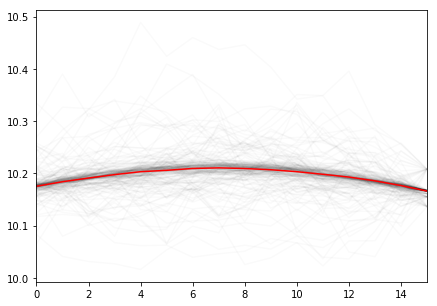

In [246]:
fig, ax = plt.subplots(1, figsize = (7, 5))
qi_totals = result.iloc[:, 1:17].sample(200).T
# np.log10(lin_levs.sum()/10).plot(color = 'r', ax = ax)
np.log10(qi_totals).plot(legend = False, alpha = 0.02, color = 'k', ax = ax)
arit_mean = np.log10(result.iloc[:, 1:17]).mean()
arit_mean.plot(color = 'r', ax = ax)

arit_mean.std()
abs(np.polyfit(range(T), arit_mean.values, 2)[0]*(T/2)**2)

In [40]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

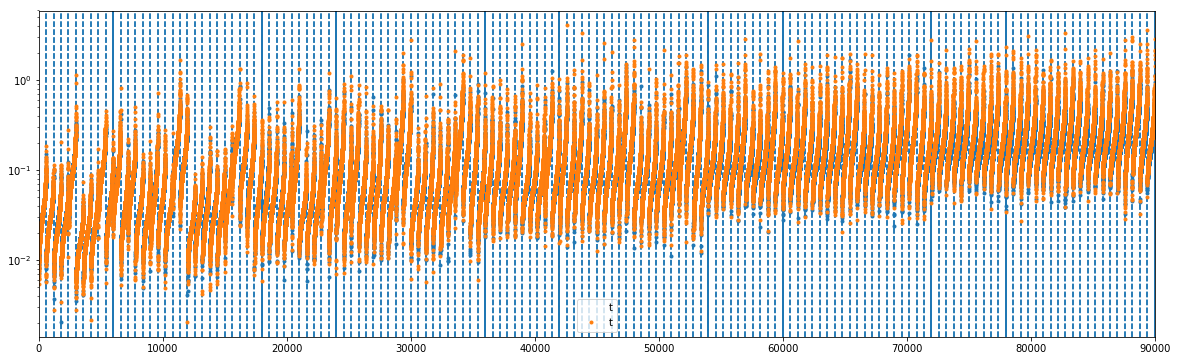

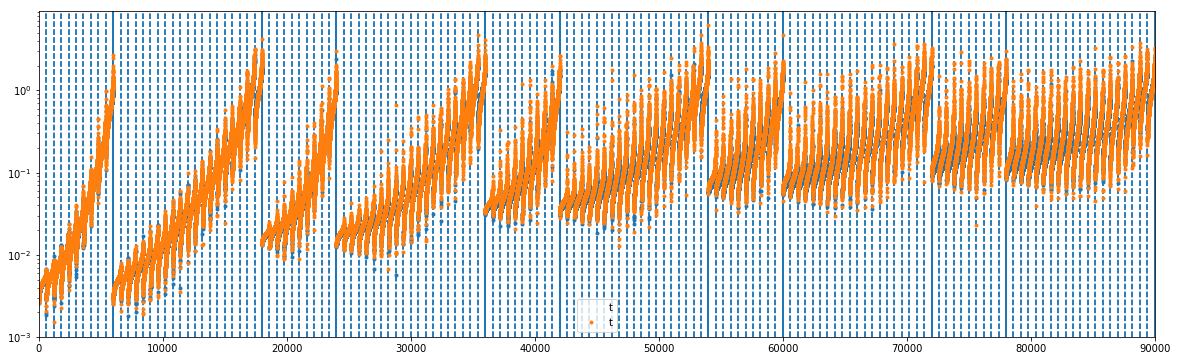

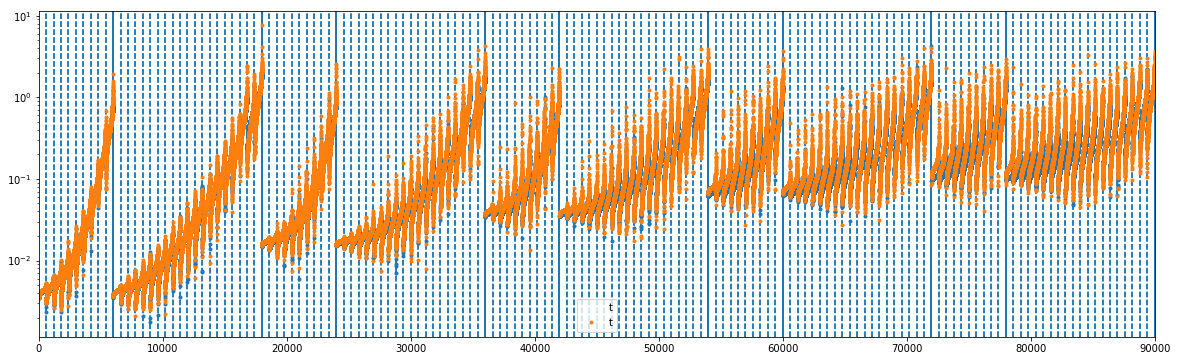

In [53]:
for j, x1 in enumerate([x_pareto, x_logn_clip3_90, x_logn_clip3]):
    sizes = ['pareto', 'logn90', 'logn'][j]
    fig, ax = plt.subplots(1, figsize = (20, 6))

    for k, dist in enumerate(['norm', 'lapl']):#, 'sbtn']):        
        filename = './../../data/processed/exp_var_'+dist+'_1s_'+sizes+'.csv'
        result = pd.read_csv(filename)
        result['t'] = result['var_diff_qi']/(result['s']**2)
        y = 't'
        sorted_ = result.sort_values(by = ['s', 'Q', 'q', y])
        [ax.axvline(l, linestyle = '--') for l in sorted_.groupby(['s','Q', 'q']).count().iloc[:, 0].cumsum().values]
        [ax.axvline(l, lw = 2) for l in sorted_.groupby(['s','Q']).count().iloc[:, 0].cumsum().values]
        sorted_.reset_index()[[y]].plot(ax = ax, marker = '.', lw = 0)
        ax.set_yscale('log')

In [43]:
# result.loc[(result.Q == 10) & (result.q == 0)].sort_values(by = 'var_qi')